# 基于经典网络架构训练图像分类模型

### 数据预处理部分：

- 数据增强：torchvision中transforms模块自带功能，比较实用
- 数据预处理：torchvision中transforms也帮我们实现好了，直接调用即可
- DataLoader模块直接读取batch数据

### 网络模块设置：

- 加载预训练模型，torchvision中有很多经典网络架构，调用起来十分方便，并且可以用人家训练好的权重参数来继续训练，也就是所谓的迁移学习
- 需要注意的是别人训练好的任务跟咱们的可不是完全一样，需要把最后的head层改一改，一般也就是最后的全连接层，改成咱们自己的任务
- 训练时可以全部重头训练，也可以只训练最后咱们任务的层，因为前几层都是做特征提取的，本质任务目标是一致的

### 网络模型保存与测试
- 模型保存的时候可以带有选择性，例如在验证集中如果当前效果好则保存
- 读取模型进行实际测试


In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
#pip install torchvision
from torchvision import transforms, models, datasets
from torchvision.models import ResNet152_Weights
#https://pytorch.org/docs/stable/torchvision/index.html
import time
import copy
import json
from PIL import Image

### 数据读取与预处理操作

In [2]:
data_dir = './flower_data/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

### 制作好数据源：
- data_transforms中指定了所有图像预处理操作
- ImageFolder假设所有的文件按文件夹保存好，每个文件夹下面存贮同一类别的图片，文件夹的名字为分类的名字

In [3]:
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
        transforms.CenterCrop(224),#从中心开始裁剪
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差
    ]),
    'valid': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
batch_size = 8

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ./flower_data/train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ./flower_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456,

In [6]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x21c42fdb6a0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x21c42fe57f0>}

In [7]:
dataset_sizes

{'train': 6552, 'valid': 818}

In [8]:
class_names

['1',
 '10',
 '100',
 '101',
 '102',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99']

### 读取标签对应的实际名字

In [9]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [10]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

### 展示下数据
- 注意tensor的数据需要转换成numpy的格式，而且还需要还原回标准化的结果

In [11]:
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

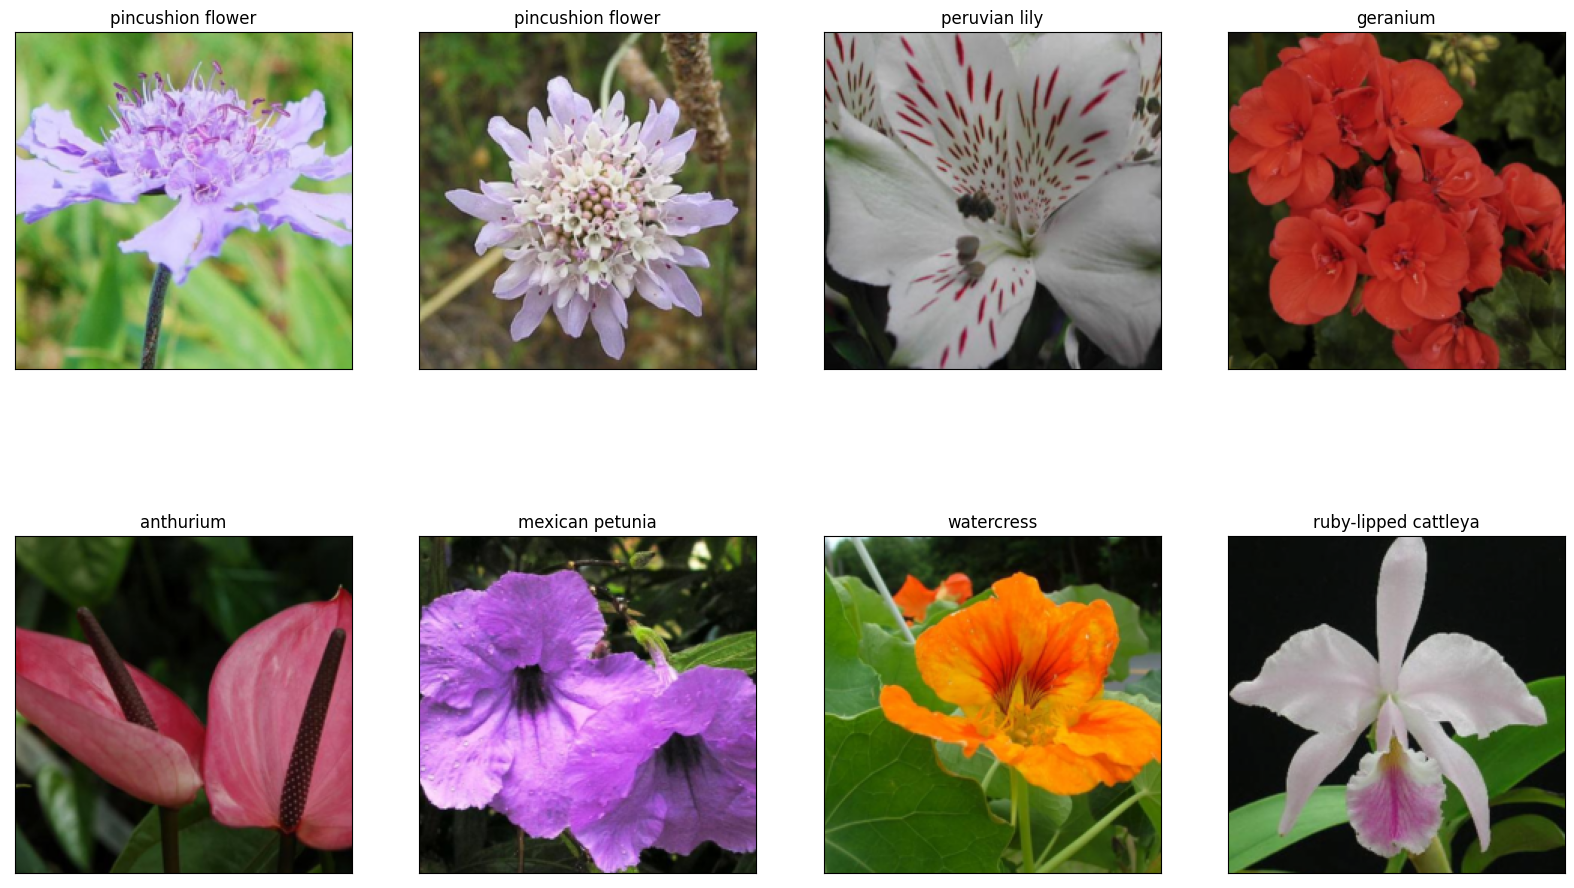

In [12]:
fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(dataloaders['valid'])
inputs, classes = next(dataiter)

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

### 加载models中提供的模型，并且直接用训练的好权重当做初始化参数
- 第一次执行需要下载，可能会比较慢，我会提供给大家一份下载好的，可以直接放到相应路径

In [13]:
model_name = 'resnet'  #可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
#是否用人家训练好的特征来做
feature_extract = True 

In [14]:
# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [15]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [16]:
model_ft = models.resnet152()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 参考pytorch官网例子

In [17]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 选择合适的模型，不同模型的初始化方法稍微有点区别
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet152
        """
        model_ft = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 102),
                                   nn.LogSoftmax(dim=1))
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

### 设置哪些层需要训练

In [18]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

#GPU计算
model_ft = model_ft.to(device)

# 模型保存
filename='checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.0.weight
	 fc.0.bias


In [19]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 优化器设置

In [20]:
# 优化器设置
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)#学习率每7个epoch衰减成原来的1/10
#最后一层已经LogSoftmax()了，所以不能nn.CrossEntropyLoss()来计算了，nn.CrossEntropyLoss()相当于logSoftmax()和nn.NLLLoss()整合
criterion = nn.NLLLoss()

### 训练模块

In [21]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False,filename=filename):
    since = time.time()
    best_acc = 0
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)

            # Learning rate decay
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step()

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

### 开始训练！

In [22]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20, is_inception=(model_name=="inception"))

Epoch 0/19
----------
Time elapsed 1m 42s
train Loss: 10.4841 Acc: 0.3078
Time elapsed 1m 51s
valid Loss: 10.1692 Acc: 0.4095
Optimizer learning rate : 0.0100000

Epoch 1/19
----------
Time elapsed 3m 29s
train Loss: 8.4941 Acc: 0.4858
Time elapsed 3m 38s
valid Loss: 12.9419 Acc: 0.4071
Optimizer learning rate : 0.0100000

Epoch 2/19
----------
Time elapsed 5m 16s
train Loss: 8.0758 Acc: 0.5485
Time elapsed 5m 26s
valid Loss: 12.5702 Acc: 0.5086
Optimizer learning rate : 0.0100000

Epoch 3/19
----------
Time elapsed 7m 5s
train Loss: 7.5021 Acc: 0.5997
Time elapsed 7m 14s
valid Loss: 14.2520 Acc: 0.4804
Optimizer learning rate : 0.0100000

Epoch 4/19
----------
Time elapsed 8m 54s
train Loss: 7.8523 Acc: 0.6119
Time elapsed 9m 3s
valid Loss: 10.6388 Acc: 0.5746
Optimizer learning rate : 0.0100000

Epoch 5/19
----------
Time elapsed 10m 42s
train Loss: 7.5326 Acc: 0.6395
Time elapsed 10m 51s
valid Loss: 11.2478 Acc: 0.6002
Optimizer learning rate : 0.0100000

Epoch 6/19
----------
Time 

### 再继续训练所有层

In [23]:
for param in model_ft.parameters():
    param.requires_grad = True

# 再继续训练所有的参数，学习率调小一点
optimizer = optim.Adam(params_to_update, lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 损失函数
criterion = nn.NLLLoss()

In [24]:
# Load the checkpoint

checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])


In [25]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=10, is_inception=(model_name=="inception"))

Epoch 0/9
----------
Time elapsed 3m 17s
train Loss: 1.8200 Acc: 0.8472
Time elapsed 3m 27s
valid Loss: 5.1679 Acc: 0.7359


d:\Miniconda\envs\DeepLearning\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Optimizer learning rate : 0.0001000

Epoch 1/9
----------
Time elapsed 6m 44s
train Loss: 1.7536 Acc: 0.8515
Time elapsed 6m 53s
valid Loss: 5.0031 Acc: 0.7274
Optimizer learning rate : 0.0001000

Epoch 2/9
----------
Time elapsed 10m 11s
train Loss: 1.8028 Acc: 0.8549
Time elapsed 10m 20s
valid Loss: 5.3669 Acc: 0.7225
Optimizer learning rate : 0.0001000

Epoch 3/9
----------
Time elapsed 13m 38s
train Loss: 1.8949 Acc: 0.8477
Time elapsed 13m 47s
valid Loss: 5.6483 Acc: 0.7213
Optimizer learning rate : 0.0001000

Epoch 4/9
----------
Time elapsed 17m 5s
train Loss: 1.7375 Acc: 0.8524
Time elapsed 17m 14s
valid Loss: 5.0501 Acc: 0.7347
Optimizer learning rate : 0.0001000

Epoch 5/9
----------
Time elapsed 20m 31s
train Loss: 1.7242 Acc: 0.8559
Time elapsed 20m 41s
valid Loss: 4.8571 Acc: 0.7347
Optimizer learning rate : 0.0001000

Epoch 6/9
----------
Time elapsed 23m 59s
train Loss: 1.7563 Acc: 0.8542
Time elapsed 24m 8s
valid Loss: 5.0252 Acc: 0.7311
Optimizer learning rate : 0.0001

### 测试网络效果

输入一张测试图像，看看网络的返回结果：

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

注意预处理方法需相同

### 加载训练好的模型

In [27]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU模式
model_ft = model_ft.to(device)

# 保存文件的名字
filename='checkpoint.pth'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### 测试数据预处理

- 测试数据处理方法需要跟训练时一直才可以 
- crop操作的目的是保证输入的大小是一致的
- 标准化操作也是必须的，用跟训练数据相同的mean和std,但是需要注意一点训练数据是在0-1上进行标准化，所以测试数据也需要先归一化
- 最后一点，PyTorch中颜色通道是第一个维度，跟很多工具包都不一样，需要转换


In [28]:
def process_image(image_path):
    # 读取测试数据
    img = Image.open(image_path)
    # Resize,thumbnail方法只能进行缩小，所以进行了判断
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop操作
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # 相同的预处理方法
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # 注意颜色通道应该放在第一个位置
    img = img.transpose((2, 0, 1))
    
    return img

In [29]:
def imshow(image, ax=None, title=None):
    """展示数据"""
    if ax is None:
        fig, ax = plt.subplots()
    
    # 颜色通道还原
    image = np.array(image).transpose((1, 2, 0))
    
    # 预处理还原
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.set_title(title)
    
    return ax

<AxesSubplot:>

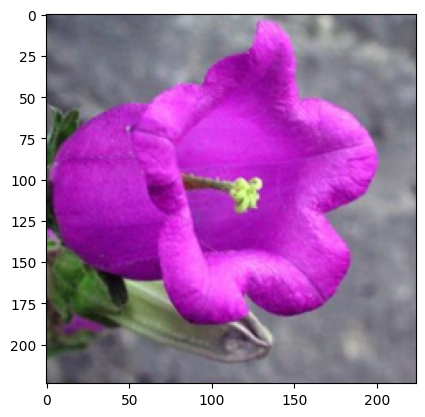

In [30]:
image_path = 'image_06621.jpg'
img = process_image(image_path)
imshow(img)

In [31]:
img.shape

(3, 224, 224)

In [32]:
# 得到一个batch的测试数据
dataiter = iter(dataloaders['valid'])
images, labels = next(dataiter)

model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

output表示对一个batch中每一个数据得到其属于各个类别的可能性

In [36]:
output.shape

torch.Size([8, 102])

### 得到概率最大的那个

In [34]:
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
preds

array([42, 28, 48,  7, 43, 71, 81, 48], dtype=int64)

### 展示预测结果

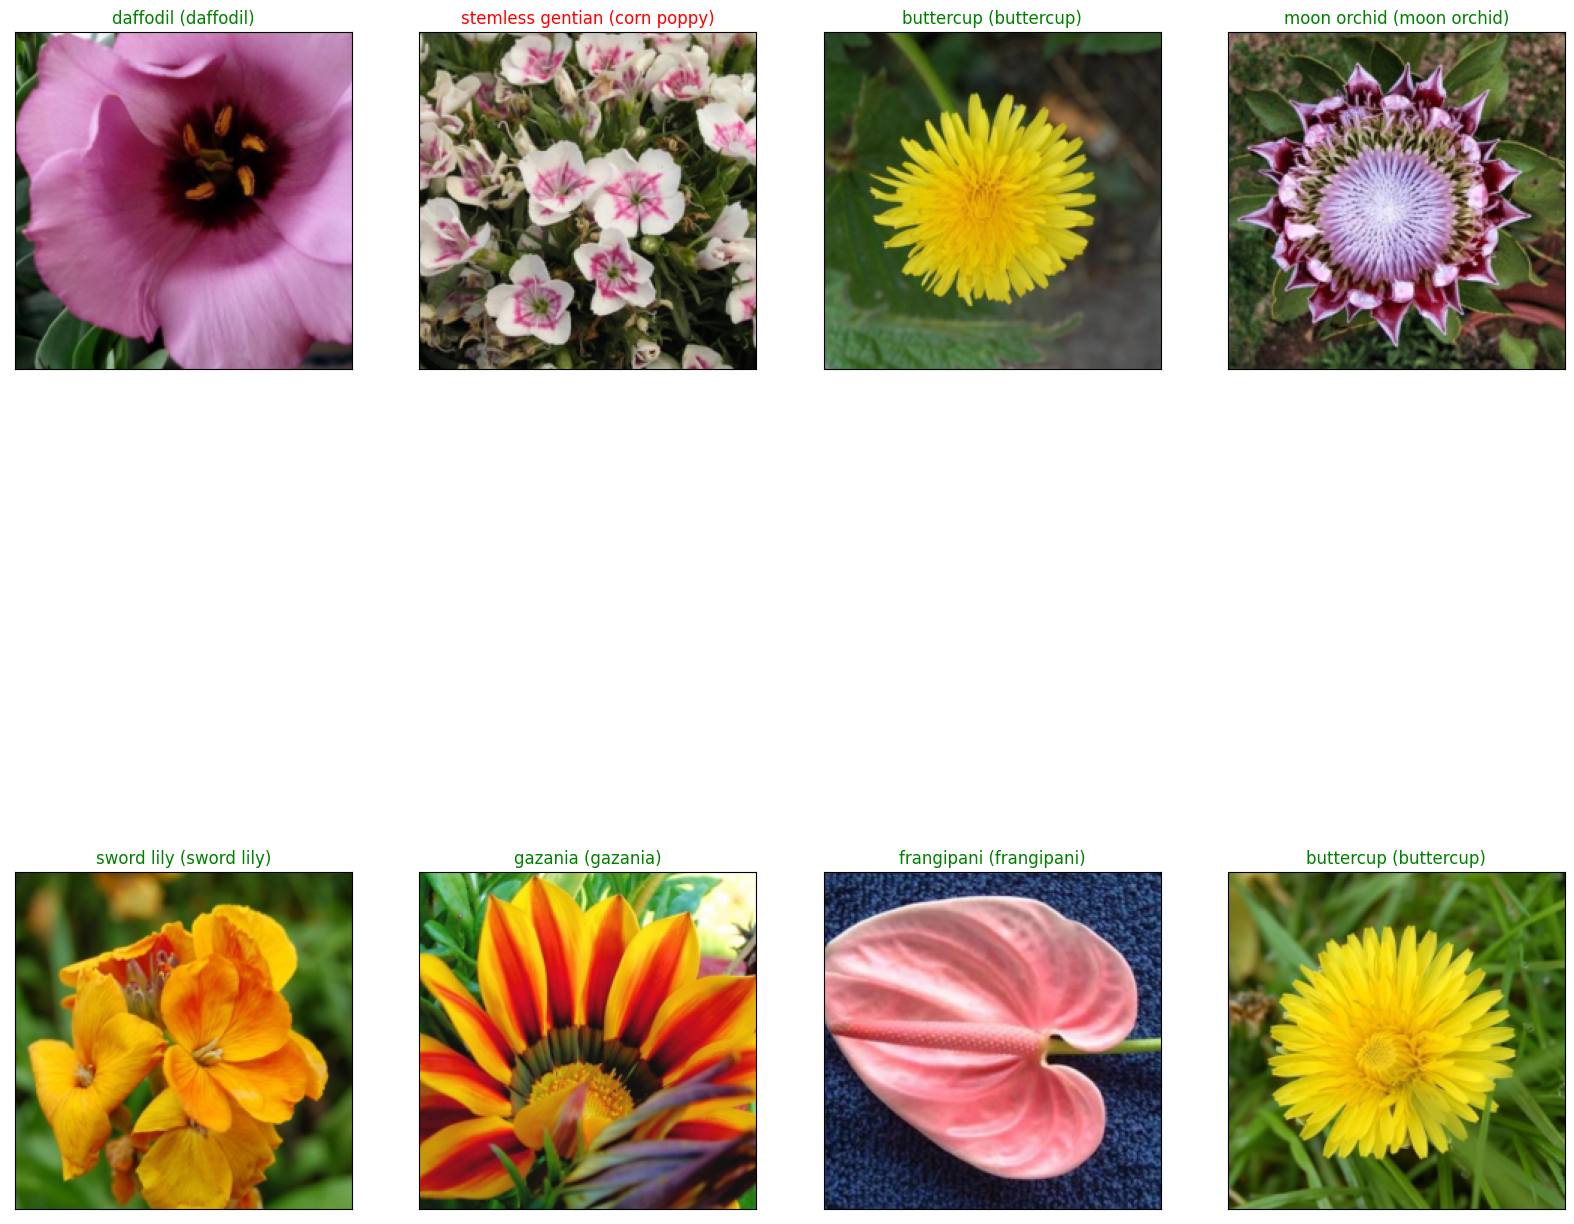

In [37]:
fig=plt.figure(figsize=(20, 20))
columns =4
rows = 2

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),
                 color=("green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else "red"))
plt.show()